<a href="https://colab.research.google.com/github/akashlal72/laptoppriceprdiction/blob/main/Laptop_price_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all the libraries
import numpy as np
import pandas as pd #importing dataset and performing data analysis
import seaborn as sns #for data visulaisation
import matplotlib.pyplot as plt #for data visulisation
import string #for puntuation mark cleaning
import statsmodels.api as sm
from statsmodels.formula.api import ols  #for perfoming annova test
from sklearn.preprocessing import OneHotEncoder

#Importing Dataset from Drive

In [2]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset.csv",encoding='latin-1')    #Reading CSV file
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


#Gathering  Data insight:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [4]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


#Data Cleaning

## Cleaning Resolution column:

In [5]:
def extract_resolution(text):      #function to extract resolution from column
    resolution = text.split(" ")[-1] #extracting resolution
    width, height = resolution.split("x")  #split function with the separator "x"
    width = int(width)  #width and height converted into string
    height = int(height)
    resolution_value = (width*height)    
    return resolution_value

df["ScreenResolution"]=df["ScreenResolution"].apply(extract_resolution)    #extracting resolution

##Cleaning Weight and Ram Column:

In [6]:
def extract_digit(text):  #function to extract digit
    ans="".join([i for i in text if i.isdigit()])    #spliting the text and extracting all digit
    return ans
#applyig above function on both the column
column=["Ram","Weight"]   #list of column from where we need to extract digit
for i in column:         
    df[i]=df[i].apply(extract_digit)   #applying extract_digit on column

## Extracting CPU [Company, Speed and processor]

In [7]:
df["Cpu_Speed"] = df["Cpu"].str.split(" ").apply(lambda x: x[-1]).str.replace("GHz", "")
df["Cpu_Vender"] = df["Cpu"].str.split(" ").apply(lambda x: x[0])
df["Cpu_Type"] = df["Cpu"].str.split(" ").apply(lambda x: x[1:4] if x[1] == "Celeron" and "Pentium" and "Xeon" else (x[1:3] if (x[1] == "Core" or x[0] == "AMD") else x[0]) )
df["Cpu_Type"] = df["Cpu_Type"].apply(lambda x: ' '.join(x))
df["Cpu_Type"]
df["Cpu_Speed"]=df["Cpu_Speed"].astype(float)

##Extracting Data from Memory column 
*based on Types of drive present and size of drive in the column*

In [8]:
df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)   #removing .0 from the memory column
#Converting TB into GB and removing GB from the column
df["Memory"] = df["Memory"].str.replace('GB', '')
df["Memory"] = df["Memory"].str.replace('TB', '000')
#Spliting the data if two types of drive are present
dummy = df["Memory"].str.split("+", n = 1, expand = True)
df["first"]= dummy[0]
df["first"]=df["first"].str.strip()
df["second"]= dummy[1]
#Extracting Memory size of each drive
df["Layer1HDD"] = df["first"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer1SSD"] = df["first"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer1Hybrid"] = df["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer1Flash_Storage"] = df["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['first'] = df['first'].str.replace(r'\D', '')
df["second"].fillna("0", inplace = True)

df["Layer2HDD"] = df["second"].apply(lambda x: 1 if "HDD" in x else 0)
df["Layer2SSD"] = df["second"].apply(lambda x: 1 if "SSD" in x else 0)
df["Layer2Hybrid"] = df["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["Layer2Flash_Storage"] = df["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df['second'] = df['second'].str.replace(r'\D', '')

df["first"] = df["first"].astype(int)
df["second"] = df["second"].astype(int)

df["Total_Memory"]=(df["first"]*(df["Layer1HDD"]+df["Layer1SSD"]+df["Layer1Hybrid"]+df["Layer1Flash_Storage"])+df["second"]*(df["Layer2HDD"]+df["Layer2SSD"]+df["Layer2Hybrid"]+df["Layer2Flash_Storage"]))
df["Memory"]=df["Total_Memory"]

#Creating column with HDD,SSD and Flash drive to fill the data in these column
df["HDD"]=(df["first"]*df["Layer1HDD"]+df["second"]*df["Layer2HDD"])
df["SSD"]=(df["first"]*df["Layer1SSD"]+df["second"]*df["Layer2SSD"])
df["Hybrid"]=(df["first"]*df["Layer1Hybrid"]+df["second"]*df["Layer2Hybrid"])
df["Flash_Storage"]=(df["first"]*df["Layer1Flash_Storage"]+df["second"]*df["Layer2Flash_Storage"])



<ipython-input-8-8e7ac160b2e4>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['first'] = df['first'].str.replace(r'\D', '')
<ipython-input-8-8e7ac160b2e4>:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['second'] = df['second'].str.replace(r'\D', '')


In [9]:
#Dropping Extra Column created to separate data from memory column
df=df.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1)

##GPU Company and Type Extract

In [10]:
gpu_distribution_list = df["Gpu"].str.split(" ")
df["Gpu_Vender"] = df["Gpu"].str.split(" ").apply(lambda x: x[0])
df["Gpu_Type"] = df["Gpu"].str.split(" ").apply(lambda x: x[1:])
df["Gpu_Type"] = df["Gpu_Type"].apply(lambda x: ' '.join(x))

##Reindexing the column 

In [11]:
df=df.reindex(columns=['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'HDD', 'SSD', 'Hybrid', 'Flash_Storage', 'Cpu_Speed',
       'Cpu_Vender', 'Cpu_Type', 'Gpu_Vender', 'Gpu_Type','Price_euros'])

##Dropping CPU and GPU column
*Data is already extracted in different*

In [12]:
df.drop(["Cpu","Gpu"],axis=1,inplace=True)

## Coverting Column with numeric data into float and Integer

In [13]:
df["Weight"] = df["Weight"].astype("float")   #convering Weight to float
df["Ram"] = df["Ram"].astype("int") #converting Ram into integer

#Exploratory Data Analysis


##Separating Categorical variable and Numeric value

In [14]:
df_numeric=df.select_dtypes(include=[int,float])
df_numeric.drop("laptop_ID",axis=1,inplace=True)
df_numeric

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Inches,ScreenResolution,Ram,Memory,Weight,HDD,SSD,Hybrid,Flash_Storage,Cpu_Speed,Price_euros
0,13.3,4096000,8,128,137.0,0,128,0,0,2.3,1339.69
1,13.3,1296000,8,128,134.0,0,0,0,128,1.8,898.94
2,15.6,2073600,8,256,186.0,0,256,0,0,2.5,575.00
3,15.4,5184000,16,512,183.0,0,512,0,0,2.7,2537.45
4,13.3,4096000,8,256,137.0,0,256,0,0,3.1,1803.60
...,...,...,...,...,...,...,...,...,...,...,...
1298,14.0,2073600,4,128,18.0,0,128,0,0,2.5,638.00
1299,13.3,5760000,16,512,13.0,0,512,0,0,2.5,1499.00
1300,14.0,1049088,2,64,15.0,0,0,0,64,1.6,229.00
1301,15.6,1049088,6,1000,219.0,1000,0,0,0,2.5,764.00


In [15]:
df_cat=df.select_dtypes(exclude=[int,float])
df_cat["Price_euros"]=df["Price_euros"]
df_cat

<ipython-input-15-325235990fdc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["Price_euros"]=df["Price_euros"]


,Company,Product,TypeName,OpSys,Cpu_Vender,Cpu_Type,Gpu_Vender,Gpu_Type,Price_euros
0,Apple,MacBook Pro,Ultrabook,macOS,Intel,Core i5,Intel,Iris Plus Graphics 640,1339.69
1,Apple,Macbook Air,Ultrabook,macOS,Intel,Core i5,Intel,HD Graphics 6000,898.94
2,HP,250 G6,Notebook,No OS,Intel,Core i5,Intel,HD Graphics 620,575.00
3,Apple,MacBook Pro,Ultrabook,macOS,Intel,Core i7,AMD,Radeon Pro 455,2537.45
4,Apple,MacBook Pro,Ultrabook,macOS,Intel,Core i5,Intel,Iris Plus Graphics 650,1803.60
...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,Windows 10,Intel,Core i7,Intel,HD Graphics 520,638.00
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,Windows 10,Intel,Core i7,Intel,HD Graphics 520,1499.00
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,Windows 10,Intel,Celeron Dual Core,Intel,HD Graphics,229.00
1301,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,Windows 10,Intel,Core i7,AMD,Radeon R5 M330,764.00


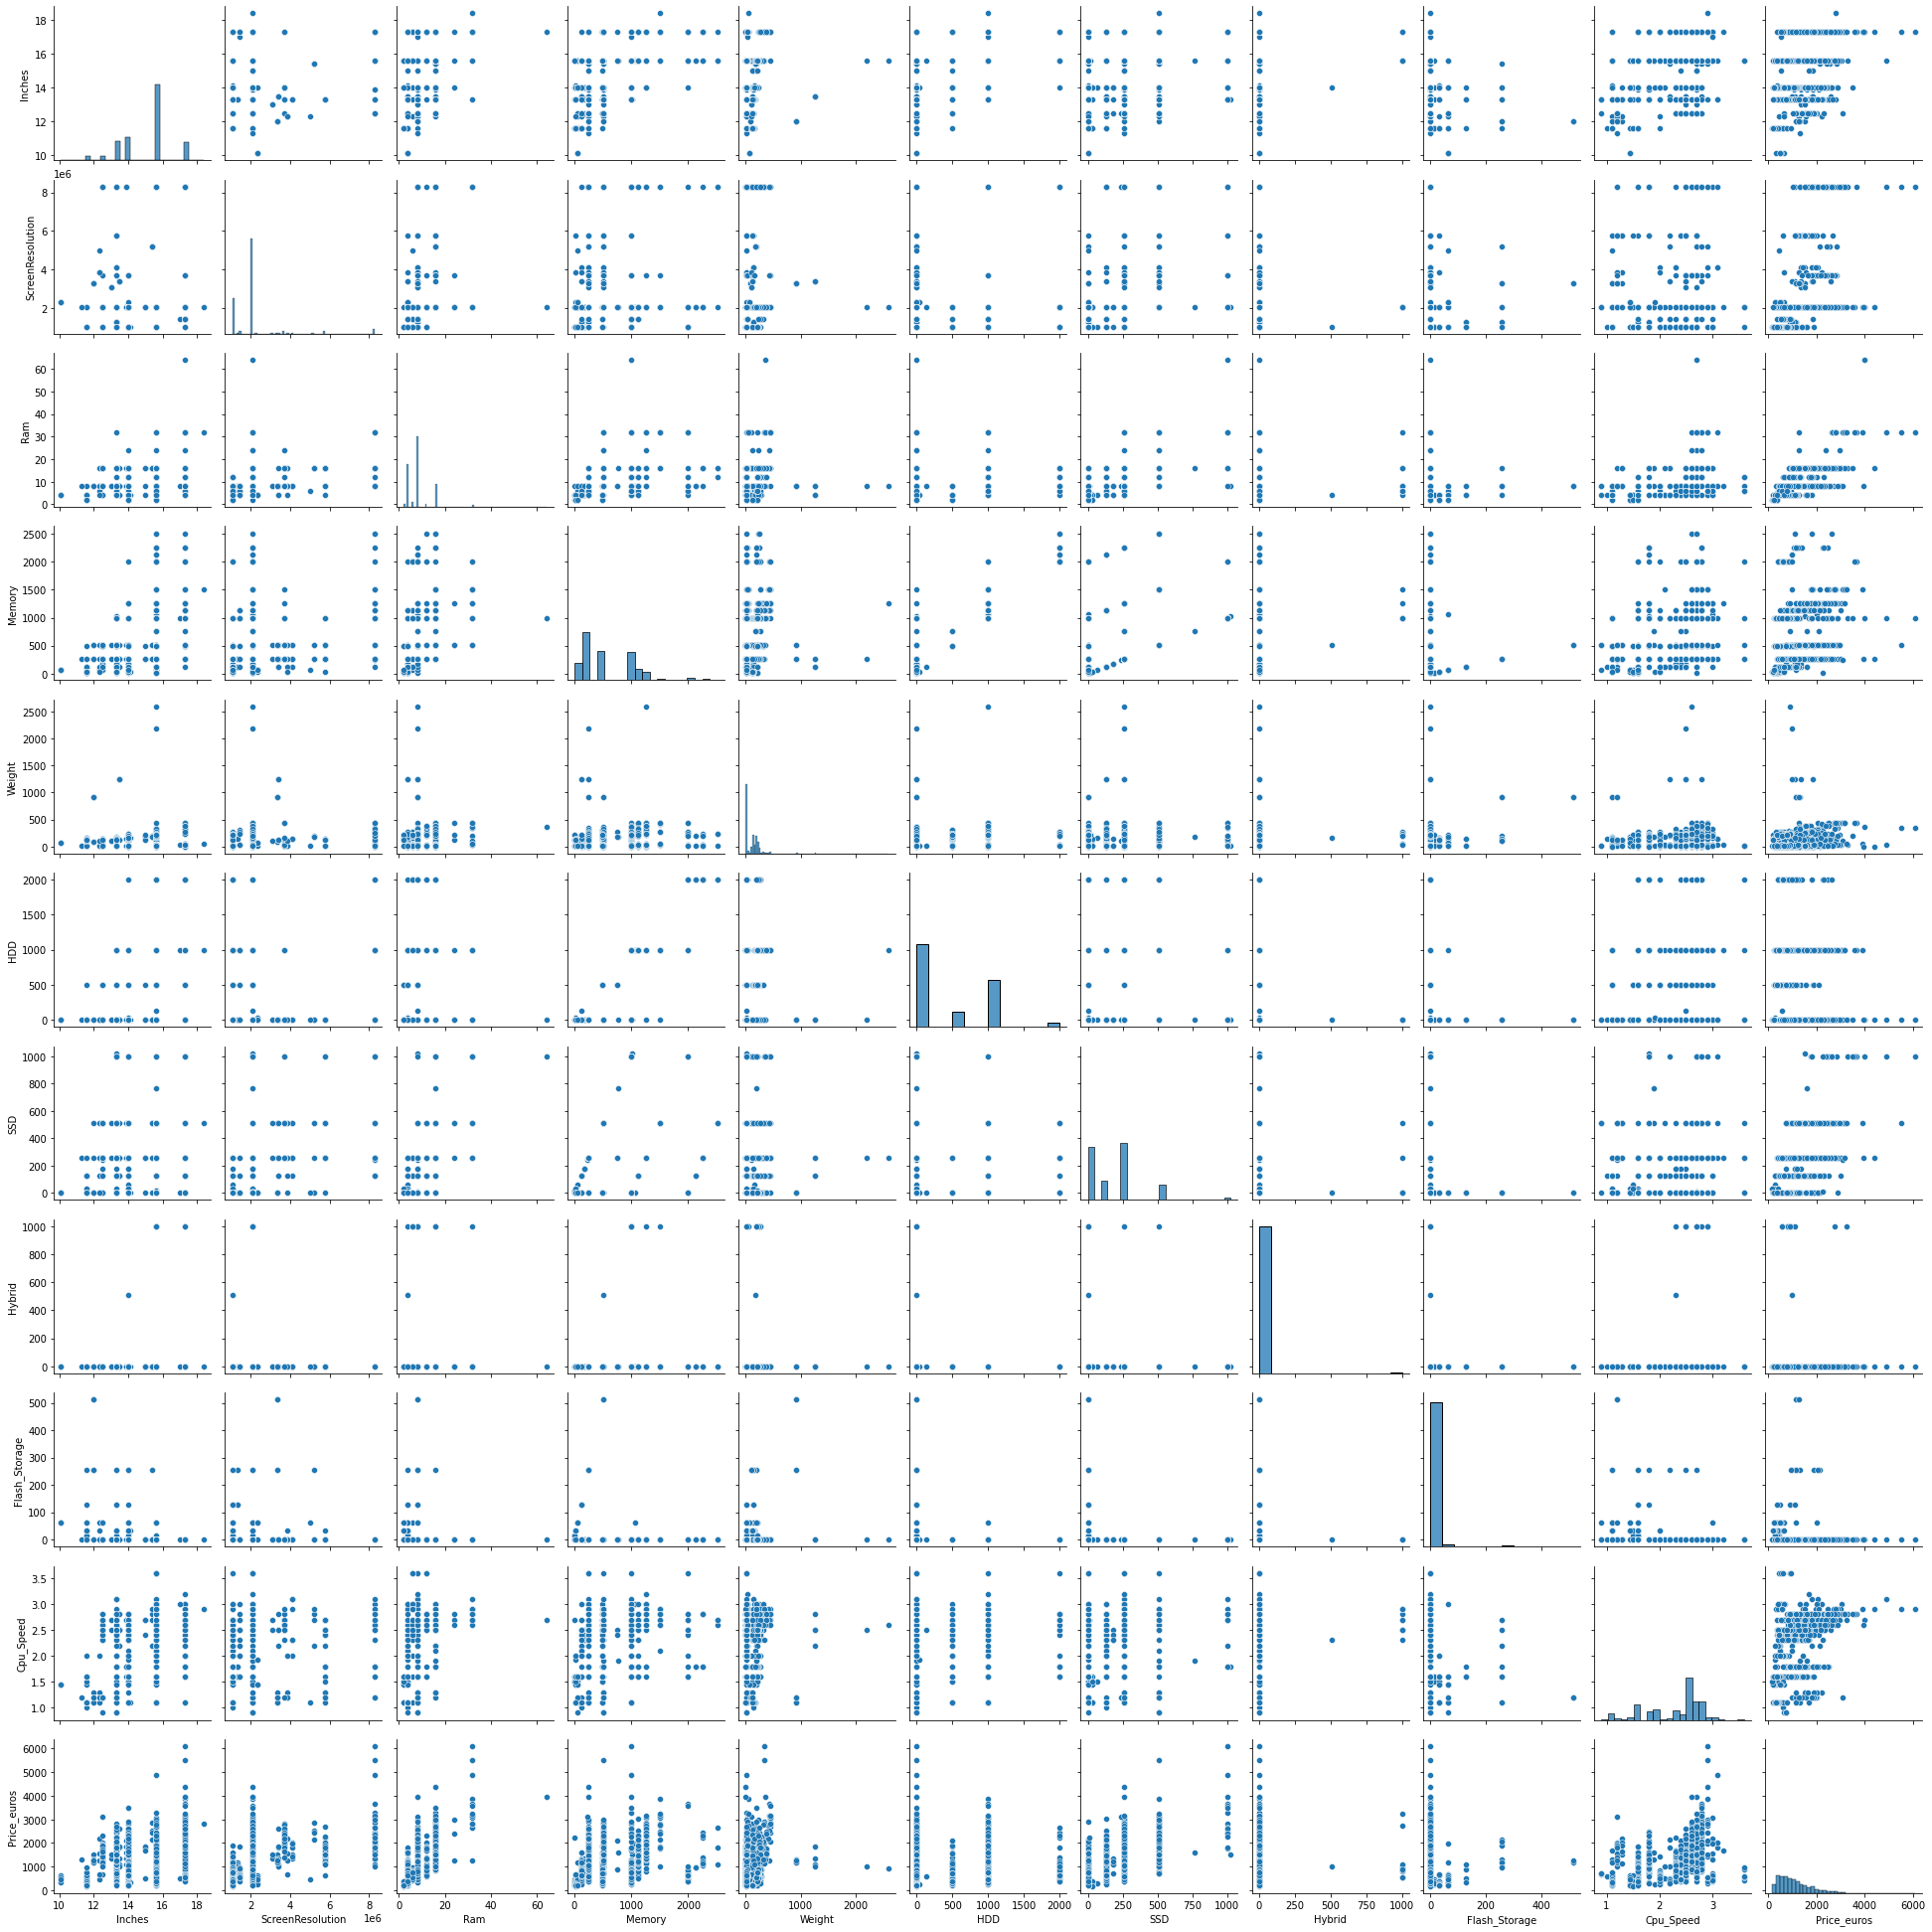

In [16]:
sns.pairplot(data=df_numeric);

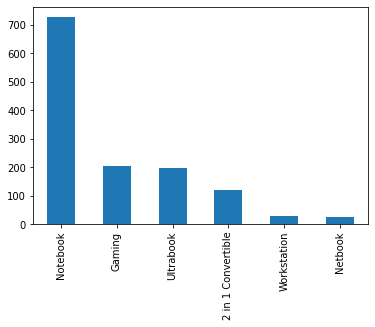

In [17]:
df["TypeName"].value_counts().plot(kind="bar")

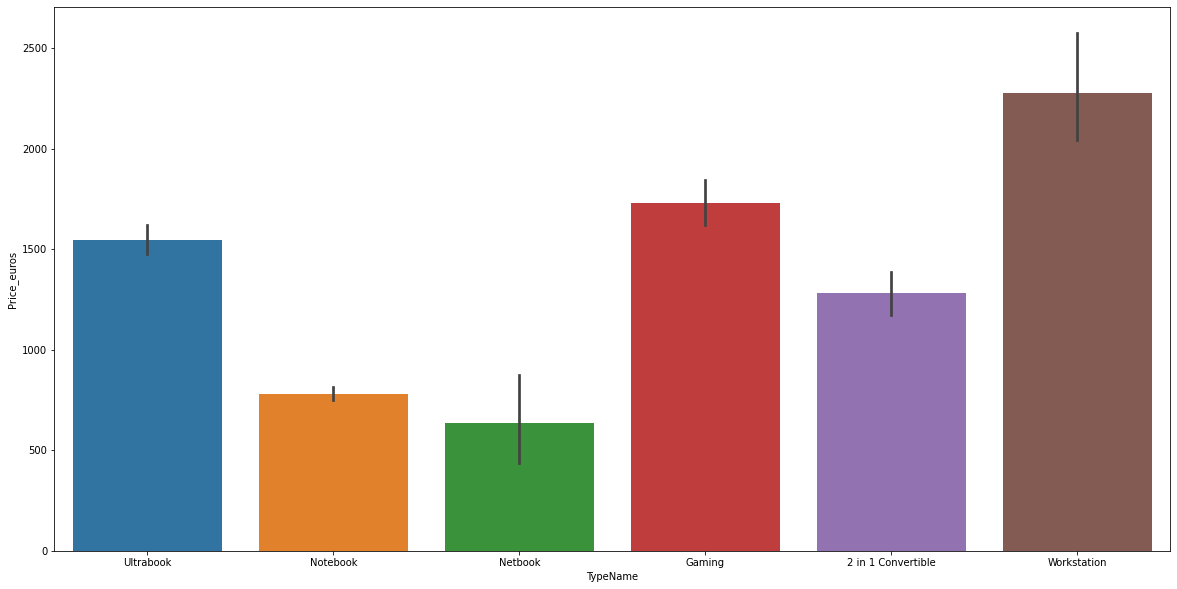

In [18]:
plt.figure(figsize=(20,10))
sns.barplot(x=df['TypeName'],y=df['Price_euros'])

##Peerson Correlation matrix:
*To check the correlation between numeric variable and Dependent variable"

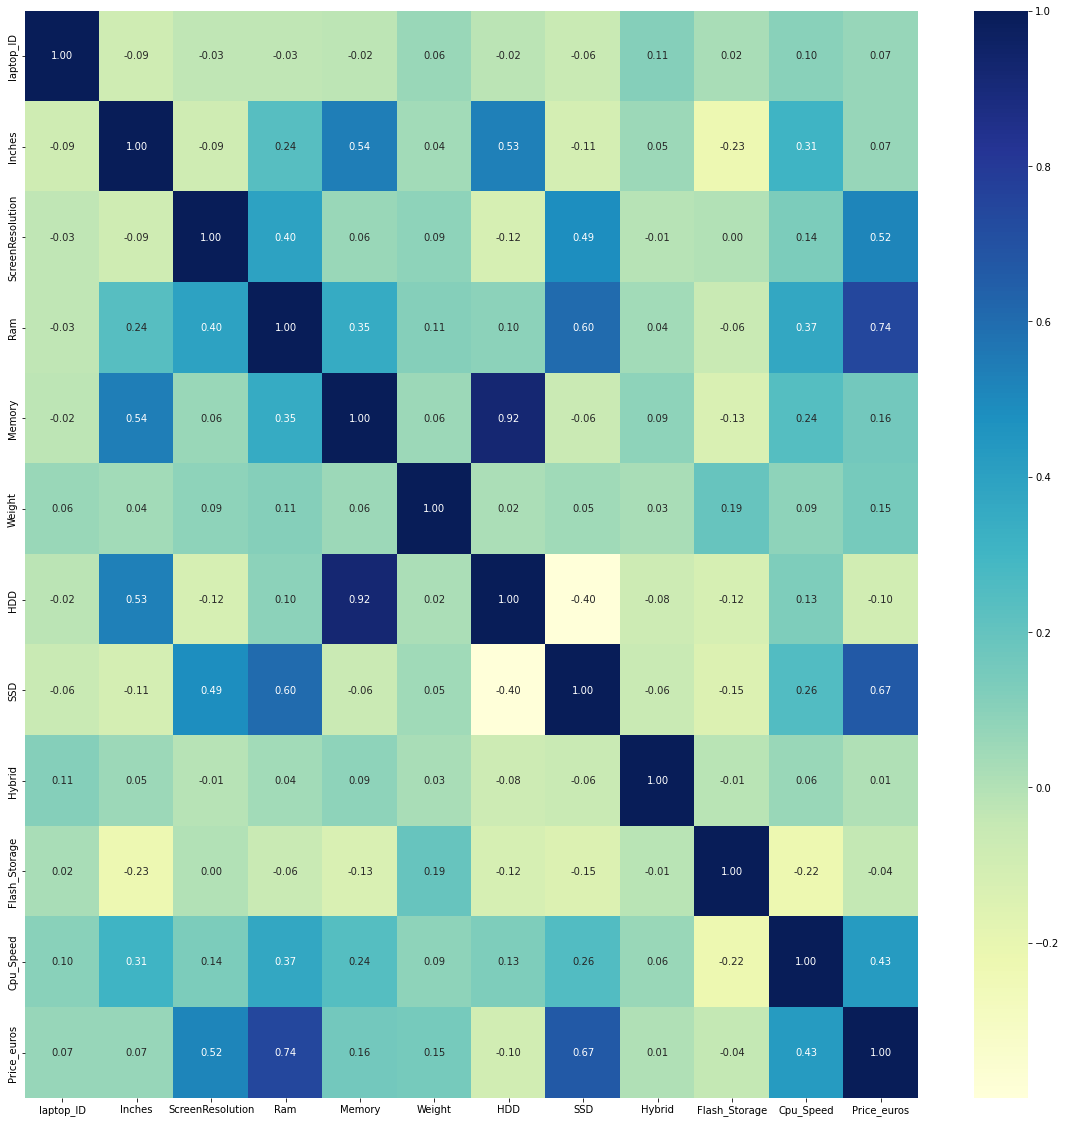

In [19]:
# Compute the correlation matrix
corr = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f")

In [20]:
df.corr()

,laptop_ID,Inches,ScreenResolution,Ram,Memory,Weight,HDD,SSD,Hybrid,Flash_Storage,Cpu_Speed,Price_euros
laptop_ID,1.000000,-0.087796,-0.031540,-0.028607,-0.024488,0.059535,-0.021703,-0.058803,0.108857,0.021936,0.102716,0.067830
Inches,-0.087796,1.000000,-0.086399,0.237993,0.538358,0.039538,0.530771,-0.107732,0.054067,-0.229803,0.307870,0.068197
ScreenResolution,-0.031540,-0.086399,1.000000,0.396358,0.064800,0.090019,-0.115648,0.485773,-0.009638,0.000562,0.135294,0.515486
Ram,-0.028607,0.237993,0.396358,1.000000,0.351363,0.113658,0.096288,0.603634,0.038461,-0.060177,0.368000,0.743007
Memory,-0.024488,0.538358,0.064800,0.351363,1.000000,0.058262,0.920622,-0.062712,0.088664,-0.127090,0.243439,0.160819
Weight,0.059535,0.039538,0.090019,0.113658,0.058262,1.000000,0.019752,0.047666,0.025443,0.190993,0.091681,0.147437
HDD,-0.021703,0.530771,-0.115648,0.096288,0.920622,0.019752,1.000000,-0.399896,-0.076596,-0.117658,0.129465,-0.096441
SSD,-0.058803,-0.107732,0.485773,0.603634,-0.062712,0.047666,-0.399896,1.000000,-0.059750,-0.147991,0.256076,0.670799
Hybrid,0.108857,0.054067,-0.009638,0.038461,0.088664,0.025443,-0.076596,-0.059750,1.000000,-0.014368,0.064139,0.007989
Flash_Storage,0.021936,-0.229803,0.000562,-0.060177,-0.127090,0.190993,-0.117658,-0.147991,-0.014368,1.000000,-0.224134,-0.040511


##ANOVA Test
*Test to find correlation between categorical variable and Dependent Variable

###Hypothesis Testing:
###Null Hypothesis(Ho): Average price is not affected by Variable.
### Alternate Hypothesis(H1):Average price is affected for each Variable

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


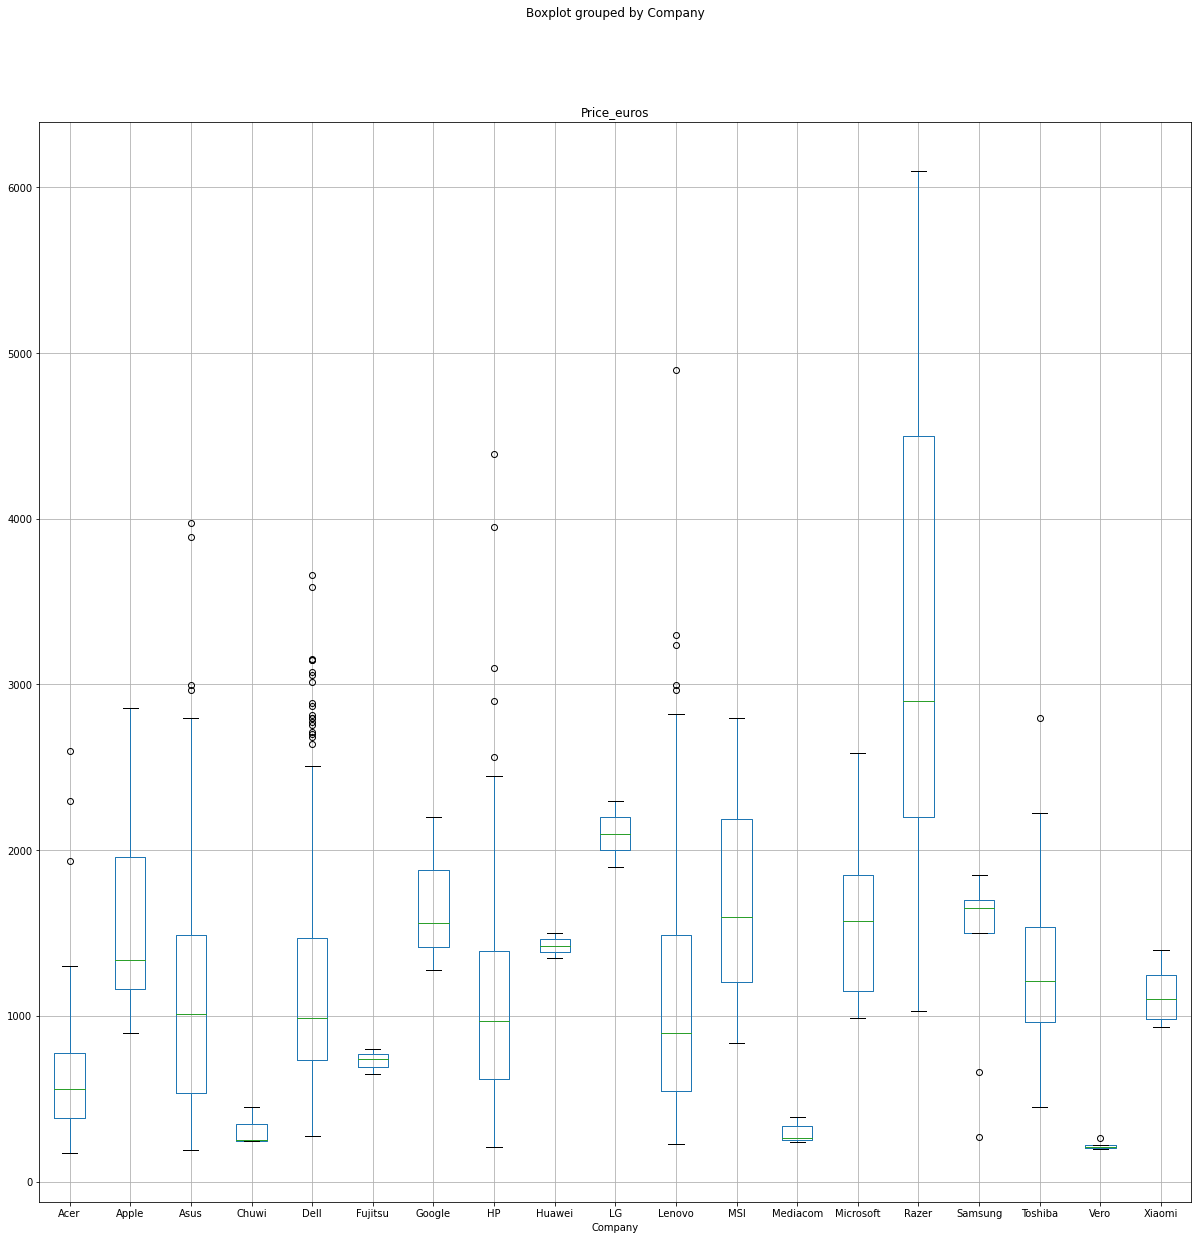

In [21]:
df.boxplot("Price_euros",by="Company",figsize=(20,20));

In [22]:
new =ols("Price_euros~Company",data=df).fit()   #fi
an=sm.stats.anova_lm(new,typ=2)
an

,sum_sq,df,F,PR(>F)
Company,1.040140e+08,18.0,13.942519,6.900837e-39
Residual,5.321610e+08,1284.0,NaN,NaN


In [23]:
an['PR(>F)'][:1]                  #Rejected Null  hypothesis becuase p value is near to zero

Company    6.900837e-39
Name: PR(>F), dtype: float64

In [24]:
df_cat.columns

Index(['Company', 'Product', 'TypeName', 'OpSys', 'Cpu_Vender', 'Cpu_Type',
       'Gpu_Vender', 'Gpu_Type', 'Price_euros'],
      dtype='object')

In [25]:
new2 =ols("Price_euros~TypeName",data=df).fit()
an2=sm.stats.anova_lm(new2,typ=2)
an2['PR(>F)'][:1]

TypeName    2.955982e-133
Name: PR(>F), dtype: float64

In [26]:
new3 =ols("Price_euros~OpSys",data=df).fit()
an3=sm.stats.anova_lm(new3,typ=2)
an3['PR(>F)'][:1]

OpSys    5.591045e-27
Name: PR(>F), dtype: float64

In [27]:
new4 =ols("Price_euros~Cpu_Vender",data=df).fit()
an4=sm.stats.anova_lm(new4,typ=2)
an4['PR(>F)'][:1]

Cpu_Vender    3.794812e-10
Name: PR(>F), dtype: float64

In [28]:
new5 =ols("Price_euros~Cpu_Type",data=df).fit()
an5=sm.stats.anova_lm(new5,typ=2)
an5['PR(>F)'][:1]

Cpu_Type    8.084268e-124
Name: PR(>F), dtype: float64

In [29]:
new6 =ols("Price_euros~Gpu_Type",data=df).fit()
an6=sm.stats.anova_lm(new6,typ=2)
an6['PR(>F)'][:1]

Gpu_Type    8.139721e-182
Name: PR(>F), dtype: float64

In [30]:
new7 =ols("Price_euros~Gpu_Vender",data=df).fit()
an7=sm.stats.anova_lm(new7,typ=2)
an7['PR(>F)'][:1]

Gpu_Vender    2.660290e-40
Name: PR(>F), dtype: float64



1.   From Above P-Values of Categorical column is nearly 0. 
2.   We Reject null hypothesis and say there is significant effect of these column on price.



## Feature Engineering

In [31]:
for i in df_cat.columns:   #finding number of unique categories
    print(i,df[i].unique().shape[0])

Company 19
Product 618
TypeName 6
OpSys 9
Cpu_Vender 3
Cpu_Type 32
Gpu_Vender 4
Gpu_Type 110
Price_euros 791


In [32]:
for i in df_cat.columns:
    print(i,df[i].value_counts().sort_values(ascending=False).head(12))

Company Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Name: Company, dtype: int64
Product XPS 13                30
Inspiron 3567         29
250 G6                21
Legion Y520-15IKBN    19
Vostro 3568           19
Inspiron 5570         18
ProBook 450           18
Alienware 17          15
Inspiron 5567         14
Satellite Pro         13
EliteBook 840         12
Latitude 5580         12
Name: Product, dtype: int64
TypeName Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: TypeName, dtype: int64
OpSys Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: OpSys, dtype: int64
Cpu_Vende

In [33]:
#One Hot encoding of column which has less unique variable
one_hot_typeName=pd.get_dummies(df["TypeName"])
one_hot_Opsys=pd.get_dummies(df["OpSys"])
one_hot_Cpuvaender=pd.get_dummies(df["Cpu_Vender"])
one_hot_GpuVender=pd.get_dummies(df["Gpu_Vender"])
df1=pd.concat([df,one_hot_Cpuvaender,one_hot_GpuVender,one_hot_typeName,one_hot_Opsys],axis=1)
df1.drop(["Cpu_Vender","Gpu_Vender","OpSys","TypeName"],axis=1,inplace=True)

In [34]:
df1.columns.shape

(38,)

In [35]:
#finding the top 12 unique value in the column based upon the frequency in dataset( column with large number of unique variable) 
top12_company=[i for i in df1.Company.value_counts().sort_values(ascending=False).head(12).index]
top12_cputype=[i for i in df1.Cpu_Type.value_counts().sort_values(ascending=False).head(12).index]
top12_Gputype=[i for i in df1.Gpu_Type.value_counts().sort_values(ascending=False).head(12).index]

In [36]:
#And now we make top 12 categories and make 12 binary variable
for label in top12_company:
   df1[label]=np.where(df1["Company"]==label,1,0)

df1[["Company"]+top12_company].head(10)

,Company,Dell,Lenovo,HP,Asus,Acer,MSI,Toshiba,Apple,Samsung,Mediacom,Razer,Microsoft
0,Apple,0,0,0,0,0,0,0,1,0,0,0,0
1,Apple,0,0,0,0,0,0,0,1,0,0,0,0
2,HP,0,0,1,0,0,0,0,0,0,0,0,0
3,Apple,0,0,0,0,0,0,0,1,0,0,0,0
4,Apple,0,0,0,0,0,0,0,1,0,0,0,0
5,Acer,0,0,0,0,1,0,0,0,0,0,0,0
6,Apple,0,0,0,0,0,0,0,1,0,0,0,0
7,Apple,0,0,0,0,0,0,0,1,0,0,0,0
8,Asus,0,0,0,1,0,0,0,0,0,0,0,0
9,Acer,0,0,0,0,1,0,0,0,0,0,0,0


In [37]:
#And now we make top 12 categories and make 12 binary variable
for label in top12_cputype:
   df1[label]=np.where(df1["Cpu_Type"]==label,1,0)

df1[["Cpu_Type"]+top12_cputype].head(10)

,Cpu_Type,Core i7,Core i5,Core i3,Celeron Dual Core,I n t e l,Core M,A9-Series 9420,Celeron Quad Core,A6-Series 9220,A12-Series 9720P,A8-Series 7410,A9-Series 9410
0,Core i5,0,1,0,0,0,0,0,0,0,0,0,0
1,Core i5,0,1,0,0,0,0,0,0,0,0,0,0
2,Core i5,0,1,0,0,0,0,0,0,0,0,0,0
3,Core i7,1,0,0,0,0,0,0,0,0,0,0,0
4,Core i5,0,1,0,0,0,0,0,0,0,0,0,0
5,A9-Series 9420,0,0,0,0,0,0,1,0,0,0,0,0
6,Core i7,1,0,0,0,0,0,0,0,0,0,0,0
7,Core i5,0,1,0,0,0,0,0,0,0,0,0,0
8,Core i7,1,0,0,0,0,0,0,0,0,0,0,0
9,Core i5,0,1,0,0,0,0,0,0,0,0,0,0


In [38]:
#And now we make top 12 categories and make 12 binary variable
for label in top12_Gputype:
   df1[label]=np.where(df1["Gpu_Type"]==label,1,0)

df1[["Gpu_Type"]+top12_Gputype].head(10)

,Gpu_Type,HD Graphics 620,HD Graphics 520,UHD Graphics 620,GeForce GTX 1050,GeForce GTX 1060,GeForce 940MX,Radeon 530,HD Graphics 500,HD Graphics 400,GeForce GTX 1070,HD Graphics,GeForce GTX 1050 Ti
0,Iris Plus Graphics 640,0,0,0,0,0,0,0,0,0,0,0,0
1,HD Graphics 6000,0,0,0,0,0,0,0,0,0,0,0,0
2,HD Graphics 620,1,0,0,0,0,0,0,0,0,0,0,0
3,Radeon Pro 455,0,0,0,0,0,0,0,0,0,0,0,0
4,Iris Plus Graphics 650,0,0,0,0,0,0,0,0,0,0,0,0
5,Radeon R5,0,0,0,0,0,0,0,0,0,0,0,0
6,Iris Pro Graphics,0,0,0,0,0,0,0,0,0,0,0,0
7,HD Graphics 6000,0,0,0,0,0,0,0,0,0,0,0,0
8,GeForce MX150,0,0,0,0,0,0,0,0,0,0,0,0
9,UHD Graphics 620,0,0,1,0,0,0,0,0,0,0,0,0


In [39]:
df1.drop(["Company","Cpu_Type","Gpu_Type","laptop_ID","Product"],axis=1,inplace=True)   #droping the column after One hot encoding

In [40]:
df1

,Inches,ScreenResolution,Ram,Memory,Weight,HDD,SSD,Hybrid,Flash_Storage,Cpu_Speed,...,UHD Graphics 620,GeForce GTX 1050,GeForce GTX 1060,GeForce 940MX,Radeon 530,HD Graphics 500,HD Graphics 400,GeForce GTX 1070,HD Graphics,GeForce GTX 1050 Ti
0,13.3,4096000,8,128,137.0,0,128,0,0,2.3,...,0,0,0,0,0,0,0,0,0,0
1,13.3,1296000,8,128,134.0,0,0,0,128,1.8,...,0,0,0,0,0,0,0,0,0,0
2,15.6,2073600,8,256,186.0,0,256,0,0,2.5,...,0,0,0,0,0,0,0,0,0,0
3,15.4,5184000,16,512,183.0,0,512,0,0,2.7,...,0,0,0,0,0,0,0,0,0,0
4,13.3,4096000,8,256,137.0,0,256,0,0,3.1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,14.0,2073600,4,128,18.0,0,128,0,0,2.5,...,0,0,0,0,0,0,0,0,0,0
1299,13.3,5760000,16,512,13.0,0,512,0,0,2.5,...,0,0,0,0,0,0,0,0,0,0
1300,14.0,1049088,2,64,15.0,0,0,0,64,1.6,...,0,0,0,0,0,0,0,0,1,0
1301,15.6,1049088,6,1000,219.0,1000,0,0,0,2.5,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df1.info()  #findinf Dtype of every column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 68 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Inches               1303 non-null   float64
 1   ScreenResolution     1303 non-null   int64  
 2   Ram                  1303 non-null   int64  
 3   Memory               1303 non-null   int64  
 4   Weight               1303 non-null   float64
 5   HDD                  1303 non-null   int64  
 6   SSD                  1303 non-null   int64  
 7   Hybrid               1303 non-null   int64  
 8   Flash_Storage        1303 non-null   int64  
 9   Cpu_Speed            1303 non-null   float64
 10  Price_euros          1303 non-null   float64
 11  AMD                  1303 non-null   uint8  
 12  Intel                1303 non-null   uint8  
 13  Samsung              1303 non-null   int64  
 14  AMD                  1303 non-null   uint8  
 15  ARM                  1303 non-null   u

###Feature Scaling
*Feature scaling should be done because some of the numeric column like weight and screen resolution are in differnt units*

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [45]:
scaling=StandardScaler()
df1[["Inches","ScreenResolution","Ram","Memory","Weight","HDD","SSD","Hybrid","Flash_Storage","Cpu_Speed"]]=scaling.fit_transform(df1[["Inches","ScreenResolution","Ram","Memory","Weight","HDD","SSD","Hybrid","Flash_Storage","Cpu_Speed"]])

## Running Linear Regression

In [46]:
from sklearn.model_selection import train_test_split   #Importing library to split train and test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

#spliting dataset into independet and depndent variable
X = df1.drop(["Price_euros"],axis=1)    #Independent Variable
y= df1["Price_euros"]    #Dependent Variable

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)   #spliting the train and test into 80:20 ratio
model = LinearRegression()   #building a linear regression model
model.fit(X_train, y_train)    #fitting the train data on linear regression model
y_pred = model.predict(X_test)   #predicting the value using test data
mse = mean_squared_error(y_test, y_pred)  #finding mean squared error
rmse = np.sqrt(mse)   #finding root mean square error
print('RMSE:', rmse)

print("MAE",mean_absolute_error(y_test,y_pred))
print("r2",r2_score(y_test,y_pred))

RMSE: 323.3660294790917
MAE 223.34371647509576
r2 0.8424761431129046


In [47]:
model.predict

<bound method LinearModel.predict of LinearRegression()>

In [48]:
X_train.head()

,Inches,ScreenResolution,Ram,Memory,Weight,HDD,SSD,Hybrid,Flash_Storage,Cpu_Speed,...,UHD Graphics 620,GeForce GTX 1050,GeForce GTX 1060,GeForce 940MX,Radeon 530,HD Graphics 500,HD Graphics 400,GeForce GTX 1070,HD Graphics,GeForce GTX 1050 Ti
617,0.408772,-0.068457,-0.075195,-0.211637,0.427310,-0.802496,1.756424,-0.095448,-0.150538,0.792712,...,0,0,0,0,0,0,0,0,0,0
1298,-0.713439,-0.068457,-0.862176,-1.033327,-0.645929,-0.802496,-0.298204,-0.095448,-0.150538,0.397569,...,0,0,0,0,0,0,0,0,0,0
318,-0.713439,-0.068457,-0.075195,-0.759430,0.498428,-0.802496,0.386672,-0.095448,-0.150538,0.397569,...,0,0,0,0,0,0,0,0,0,0
250,0.408772,-0.068457,-0.075195,0.832594,0.582477,1.136914,-0.983080,-0.095448,-0.150538,-0.985431,...,1,0,0,0,0,0,0,0,0,0
228,1.601121,-0.068457,-0.075195,0.310479,0.976860,0.167209,0.386672,-0.095448,-0.150538,0.397569,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_train.values[0]

array([ 0.40877166, -0.06845664, -0.07519506, -0.21163665,  0.4273097 ,
       -0.80249589,  1.75642378, -0.09544762, -0.15053764,  0.79271164,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [50]:
model.predict(X_train.values[0].reshape(1, -1))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([1749.375])

# Requirement from Client:


1.   Client should have basic platform to run the pyhton code.
2.   Client Should input all the data to get predict the price.(Company,TypeName,	Inches,	ScreenResolution,	Cpu,	Ram,	Memory,	Gpu,	OpSys,	Weight)
3. Client Should make sure they fill all the input without leaving any column.






To access the file on google colab go to the below link.

https://colab.research.google.com/drive/1_D9rnD491wVyu6HfCqQSdo92b2jjLIaf?usp=sharing